In [1]:
import os; os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from tqdm.auto import tqdm

from pathlib import Path
import numpy as np
import pandas as pd
import scipy
from pickle import dump, load
import matplotlib.pyplot as plt
import cv2
import random
from IPython.display import clear_output
import tensorflow as tf
# import plotly.express as px
from tensorflow.keras import layers
from functools import partial
from PIL import Image
import re

import torch
import piq




In [2]:

(Xtrain, Ytrain), (Xtest, Ytest) = tf.keras.datasets.mnist.load_data()

Xtrain = np.expand_dims(Xtrain,-1)
Xtest = np.expand_dims(Xtest,-1)


def var_pos(X, y, desp_h, desp_v):
  X_big = np.zeros((X.shape[0],56,56,1))
  X_big[:,14+desp_v:14+28+desp_v,14+desp_h:14+28+desp_h] = X[:,:,:]
  return X_big.astype(np.float32), y.astype(np.int32)

def _fixup_shape(images, labels):
    images.set_shape((256,56,56,1))
    labels.set_shape((256,))
    return images, labels

dst_train = tf.data.Dataset.from_tensor_slices((Xtest, Ytest)).batch(256, drop_remainder=True)

var_pos_loquesea = partial(var_pos,desp_h = 0, desp_v = 0)

def tf_function(x,y):
  return tf.numpy_function(var_pos_loquesea, [x,y], (tf.float32, tf.int32))

dst_big = dst_train.map(tf_function).map(_fixup_shape)



Xtrain_big_VGG = dst_big.map(lambda x,y: (tf.keras.applications.vgg16.preprocess_input(
    tf.image.grayscale_to_rgb(tf.convert_to_tensor(x)), data_format=None
),y) )



2023-06-16 12:24:26.732196: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-16 12:24:26.733392: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: mlui01.ific.uv.es
2023-06-16 12:24:26.733429: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: mlui01.ific.uv.es
2023-06-16 12:24:26.737632: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.85.12
2023-06-16 12:24:26.737730: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.85.12
2023-06-16 12:24:26.737748: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 525.85.12
2023-06-16 12:24:26.770977: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following

In [3]:

VGG16 = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(56,56,3),
)

for capa in VGG16.layers:
    capa.trainable = False

    model_VGG16 = tf.keras.Sequential([
    VGG16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation = "softmax")
])


In [4]:
VGG16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 56, 56, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 56, 56, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 56, 56, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 28, 28, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 28, 28, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 28, 28, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 14, 14, 128)       0     

In [5]:
for i,layer in enumerate(VGG16.layers):
    print(i,layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


In [6]:
inputs = VGG16.input
GAPMP1 = layers.GlobalAveragePooling2D()(VGG16.layers[3].output)
GAPMP2 = layers.GlobalAveragePooling2D()(VGG16.layers[6].output)
GAPMP3 = layers.GlobalAveragePooling2D()(VGG16.layers[10].output)
GAPMP4 = layers.GlobalAveragePooling2D()(VGG16.layers[14].output)
GAPMP5 = layers.GlobalAveragePooling2D()(VGG16.layers[18].output)

GAPFinal = tf.concat([GAPMP1,GAPMP2,GAPMP3,GAPMP4,GAPMP5], -1)

outputs = layers.Dense(10, activation = "softmax")(GAPFinal)

In [7]:
ModeloVGGGAP = tf.keras.Model(inputs,outputs)

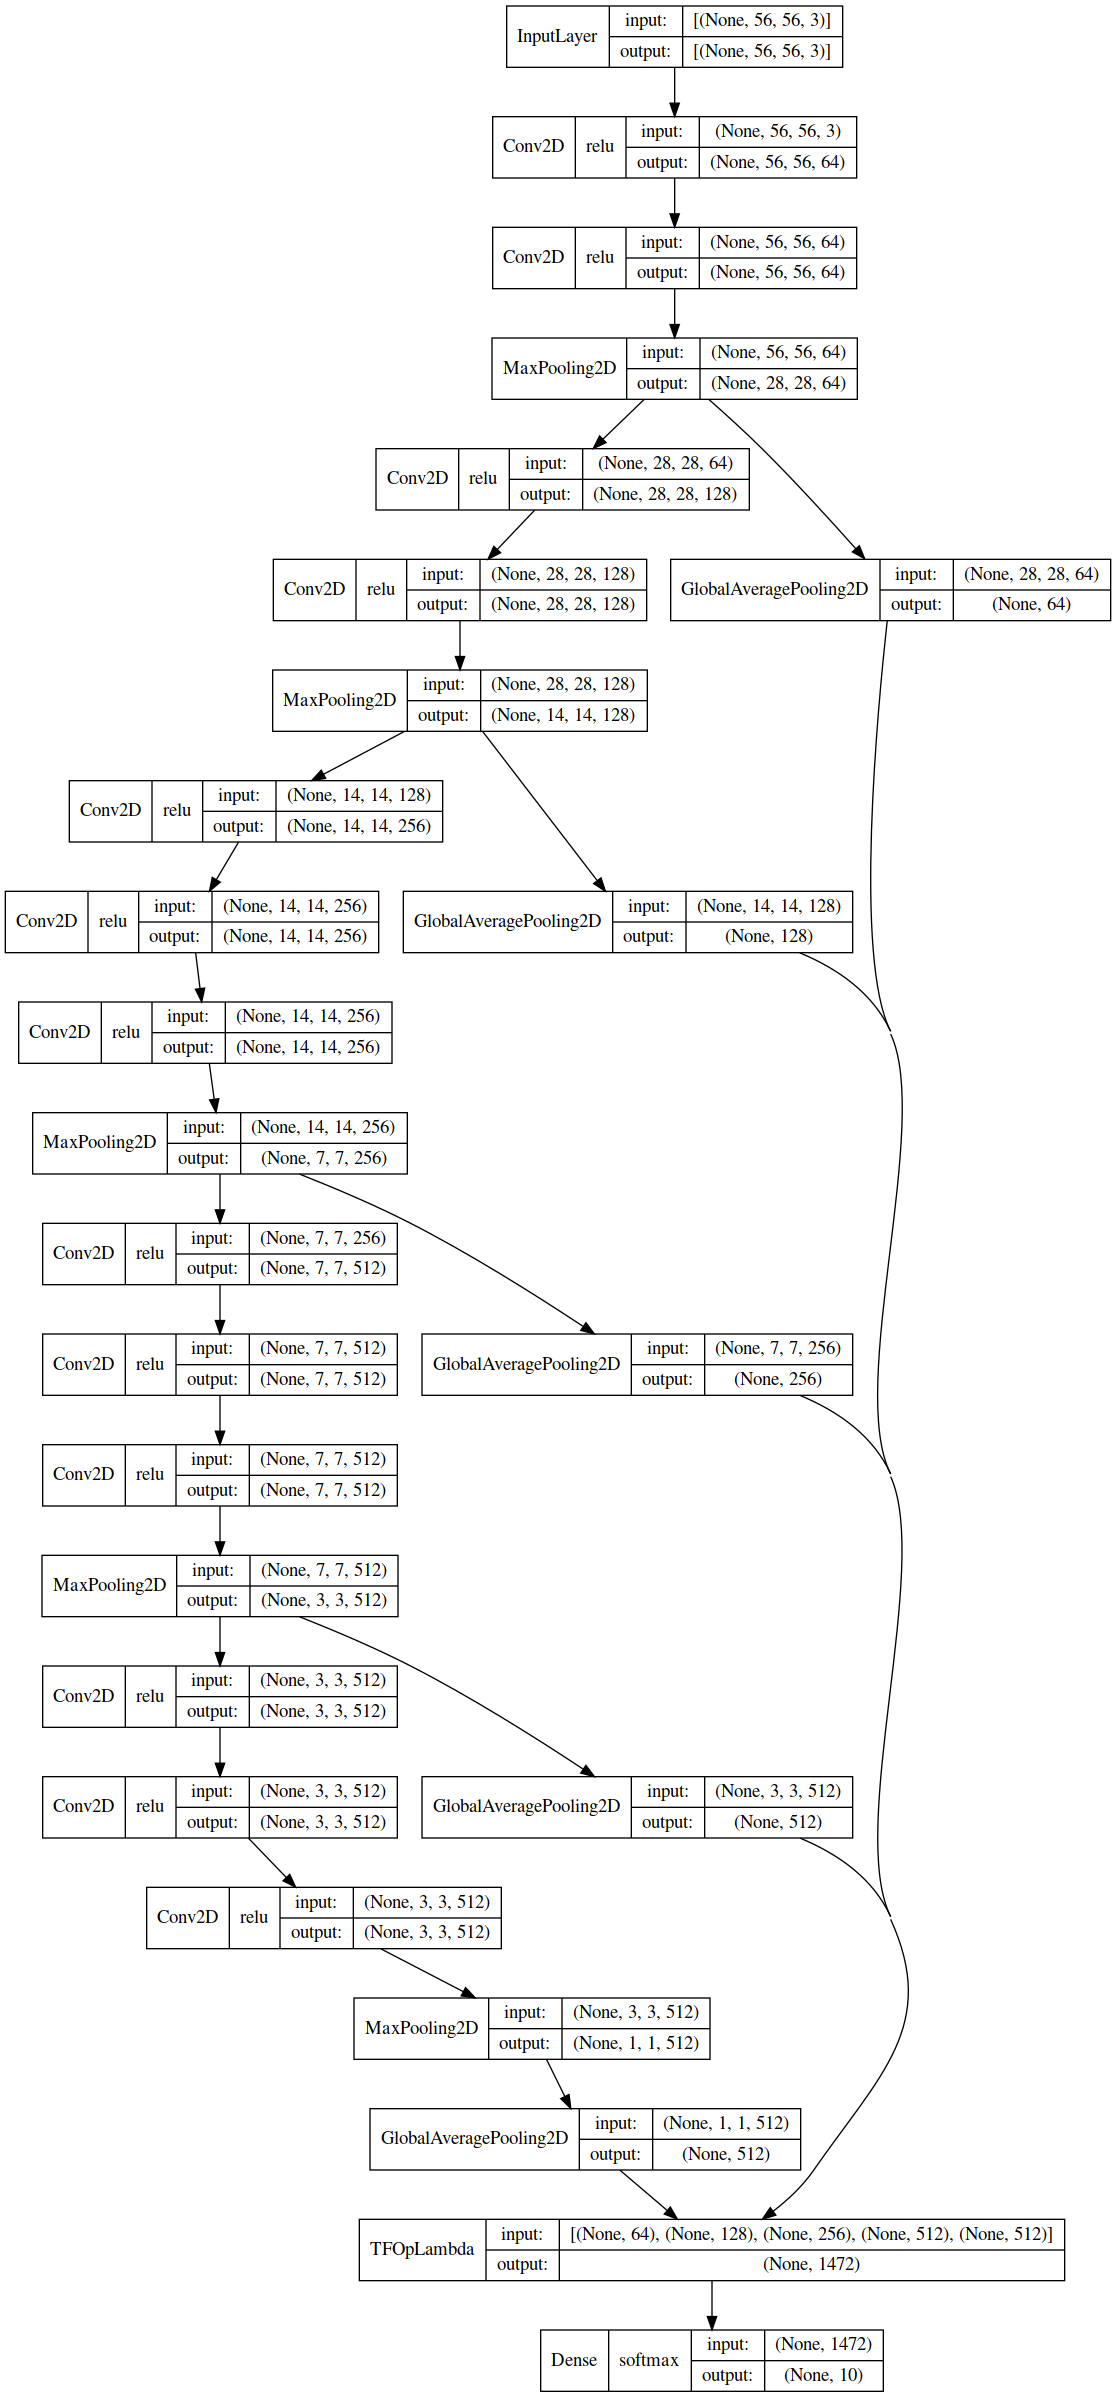

In [8]:
tf.keras.utils.plot_model(
    ModeloVGGGAP,
    #to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)

In [9]:

ModeloVGGGAP.compile(optimizer = "adam", metrics=["accuracy"], loss = "sparse_categorical_crossentropy")
history = ModeloVGGGAP.fit(Xtrain_big_VGG, epochs = 15)



Epoch 1/15
39/39 [==============================] - 16s 318ms/step - loss: 98.9036 - accuracy: 0.3893
Epoch 2/15
39/39 [==============================] - 12s 302ms/step - loss: 8.4417 - accuracy: 0.7871
Epoch 3/15
39/39 [==============================] - 12s 298ms/step - loss: 4.0233 - accuracy: 0.8761
Epoch 4/15
39/39 [==============================] - 12s 305ms/step - loss: 2.7823 - accuracy: 0.9098
Epoch 5/15
39/39 [==============================] - 12s 300ms/step - loss: 2.2717 - accuracy: 0.9227
Epoch 6/15
39/39 [==============================] - 12s 297ms/step - loss: 1.8517 - accuracy: 0.9336
Epoch 7/15
39/39 [==============================] - 12s 298ms/step - loss: 1.5663 - accuracy: 0.9416
Epoch 8/15
39/39 [==============================] - 12s 295ms/step - loss: 1.3526 - accuracy: 0.9460
Epoch 9/15
39/39 [==============================] - 12s 299ms/step - loss: 1.3423 - accuracy: 0.9443
Epoch 10/15
39/39 [==============================] - 12s 295ms/step - loss: 1.0963 - accur

In [10]:
ModeloVGGGAP.save("./ModeloVGGGAP_15.h5")

In [11]:

# ResNet50

Xtrain_big_RN = dst_big.map(lambda x,y: (tf.keras.applications.resnet50.preprocess_input(
    tf.image.grayscale_to_rgb(tf.convert_to_tensor(x)), data_format=None),y) )

ResNet50 = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(56,56,3)
)

for capa in ResNet50.layers:
    capa.trainable = False

model_ResNet50 = tf.keras.Sequential([
    ResNet50,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation = "softmax")
])


In [12]:
capas_out = []

for i,layer in enumerate(ResNet50.layers):
    if layer.name.endswith("out"):
        print(i,layer.name)
        capas_out.append(layer)

18 conv2_block1_out
28 conv2_block2_out
38 conv2_block3_out
50 conv3_block1_out
60 conv3_block2_out
70 conv3_block3_out
80 conv3_block4_out
92 conv4_block1_out
102 conv4_block2_out
112 conv4_block3_out
122 conv4_block4_out
132 conv4_block5_out
142 conv4_block6_out
154 conv5_block1_out
164 conv5_block2_out
174 conv5_block3_out


In [13]:
inputs = ResNet50.input
GAPS = [layers.GlobalAveragePooling2D()(l.output) for l in capas_out]

GAPFinal = tf.concat(GAPS, -1)

outputs = layers.Dense(10, activation = "softmax")(GAPFinal)

In [14]:
ModeloRNGAP = tf.keras.Model(inputs,outputs)

In [15]:

ModeloRNGAP.compile(optimizer = "adam", metrics=["accuracy"], loss = "sparse_categorical_crossentropy")


In [16]:

history = ModeloRNGAP.fit(Xtrain_big_RN, epochs = 15)



Epoch 1/15


39/39 [==============================] - 12s 242ms/step - loss: 3.2236 - accuracy: 0.4813
Epoch 2/15
39/39 [==============================] - 10s 245ms/step - loss: 0.4670 - accuracy: 0.8493
Epoch 3/15
39/39 [==============================] - 10s 244ms/step - loss: 0.3292 - accuracy: 0.9006
Epoch 4/15
39/39 [==============================] - 10s 245ms/step - loss: 0.2771 - accuracy: 0.9173
Epoch 5/15
39/39 [==============================] - 10s 244ms/step - loss: 0.2353 - accuracy: 0.9292
Epoch 6/15
39/39 [==============================] - 9s 237ms/step - loss: 0.2044 - accuracy: 0.9399
Epoch 7/15
39/39 [==============================] - 10s 245ms/step - loss: 0.1808 - accuracy: 0.9480
Epoch 8/15
39/39 [==============================] - 9s 236ms/step - loss: 0.1614 - accuracy: 0.9548
Epoch 9/15
39/39 [==============================] - 10s 239ms/step - loss: 0.1454 - accuracy: 0.9602
Epoch 10/15
39/39 [==============================] - 10s 245ms/step - loss: 0.1324 - accuracy: 0.9634
Ep

In [17]:
ModeloRNGAP.save("./ModeloRNGAP_15.h5")

In [18]:


# Metricas

desps_h = range(-10,11)
desps_v = range(-10,11)
metricas_VGG = {}
metricas_RN50 = {}
 
for desp_h in tqdm(desps_h):
    for desp_v in tqdm(desps_v): 
        var_pos2 = partial(var_pos,desp_h = desp_h, desp_v = desp_v)

        def tf_function2(x,y):
            return tf.numpy_function(var_pos2, [x,y], (tf.float32, tf.int32))

        dst_big = dst_train.map(tf_function2)

        X_VGG = dst_big.map(lambda x,y: (tf.keras.applications.vgg16.preprocess_input(
    tf.image.grayscale_to_rgb(tf.convert_to_tensor(x)), data_format=None),y) )
        
        X_RN50 = dst_big.map(lambda x,y: (tf.keras.applications.resnet50.preprocess_input(
    tf.image.grayscale_to_rgb(tf.convert_to_tensor(x)), data_format=None),y) )
        
        results_VGG = model_VGG16.evaluate(X_VGG)
        results_RN50 = model_ResNet50.evaluate(X_RN50)

        metricas_VGG[(desp_h, desp_v)] = results_VGG
        metricas_RN50[(desp_h, desp_v)] = results_RN50

with open(f"metricas_VGG3.pkl", "wb") as f:
    dump(metricas_VGG, f)

with open(f"metricas_RN503.pkl", "wb") as f:
    dump(metricas_RN50, f)


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.